# Network inference of categorical variables: non-sequential data

In [1]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline

#import inference

In [2]:
# setting parameter:
np.random.seed(1)

n = 20 # number of positions
m = 5 # number of values at each position
l = int(4*((n*m)**2)) # number of samples
g = 2.

sp = 0.0 # degree of sparsity
nm = n*m

In [3]:
def itab(n,m):    
    i1 = np.zeros(n)
    i2 = np.zeros(n)
    for i in range(n):
        i1[i] = i*m
        i2[i] = (i+1)*m

    return i1.astype(int),i2.astype(int)

In [4]:
# generate coupling matrix w0:
def generate_interactions(n,m,g,sp):
    nm = n*m
    w = np.random.normal(0.0,g/np.sqrt(nm),size=(nm,nm))
    i1tab,i2tab = itab(n,m)

    for i in range(n):
        for j in range(n):
            if (j != i) and (np.random.rand() < sp): 
                w[i1tab[i]:i2tab[i],i1tab[j]:i2tab[j]] = 0.
                           
    for i in range(n):        
        i1,i2 = i1tab[i],i2tab[i]              
        w[:,i1:i2] -= w[:,i1:i2].mean(axis=1)[:,np.newaxis]            

    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        w[i1:i2,i1:i2] = 0.   # no self-interactions

    for i in range(nm):
        for j in range(nm):
            if j > i: w[i,j] = w[j,i]
        
    return w

In [5]:
def generate_external_local_field(n,m,g):  
    nm = n*m
    h0 = np.random.normal(0.0,g/np.sqrt(nm),size=nm)

    i1tab,i2tab = itab(n,m) 
    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        h0[i1:i2] -= h0[i1:i2].mean(axis=0)

    return h0

In [6]:
i1tab,i2tab = itab(n,m)

In [7]:
w_true = generate_interactions(n,m,g,sp)

In [8]:
print(w_true.shape)

(100, 100)


In [9]:
h0_true = generate_external_local_field(n,m,g)

In [10]:
def generate_sequences(w,h0,n,m,l):
    i1tab,i2tab = itab(n,m)
    
    # initial s (categorical variables)
    s_ini = np.random.randint(0,m,size=(l,n)) # integer values

    # onehot encoder 
    enc = OneHotEncoder(n_values=m)
    s = enc.fit_transform(s_ini).toarray()

    nrepeat = 10*n
    for irepeat in range(nrepeat):
        for i in range(n):
            i1,i2 = i1tab[i],i2tab[i]

            h = h0[np.newaxis,i1:i2] + s.dot(w[:,i1:i2])  # h[t,i1:i2]

            k0 = np.argmax(s[:,i1:i2],axis=1)
            for t in range(l):
                k = np.random.randint(0,m)                
                while k == k0[t]:
                    k = np.random.randint(0,m)
                
                if np.exp(h[t,k] - h[t,k0[t]]) > np.random.rand():
                    s[t,i1:i2],s[t,i1+k] = 0.,1.

        if irepeat%n == 0: print(irepeat)                    
    return s

In [11]:
s = generate_sequences(w_true,h0_true,n,m,l)

0
20
40
60
80
100
120
140
160
180


In [12]:
s.shape

(40000, 100)

In [18]:
def fit_multiplicative(s,n,m):
    l = s.shape[0]
    i1tab,i2tab = itab(n,m) 

    y = s.copy()
    
    nloop = 20
    nm1 = nm - m
    
    w_infer = np.zeros((nm,nm))
    h0_infer = np.zeros(nm)

    wini = np.random.normal(0.0,1./np.sqrt(nm),size=(nm1,nm))
    h0ini = np.random.normal(0.0,1./np.sqrt(nm),size=nm)

    
    for i in range(n):
        i1,i2 = i1tab[i],i2tab[i]
        x = np.hstack([s[:,:i1],s[:,i2:]])
        
        #-------------------------------------------------------------
        # covariance[ia,ib]
        cab_inv = np.empty((m,m,nm1,nm1))
        eps = np.empty((m,m,l))
        for ia in range(m):
            for ib in range(m):
                if ib != ia:
                    eps[ia,ib,:] = y[:,i1+ia] - y[:,i1+ib]

                    which_ab = eps[ia,ib,:] !=0.                    
                    xab = x[which_ab]          

                    # ----------------------------
                    xab_av = np.mean(xab,axis=0)
                    dxab = xab - xab_av
                    cab = np.cov(dxab,rowvar=False,bias=True)
                    cab_inv[ia,ib,:,:] = linalg.pinv(cab,rcond=1e-15)
        #-------------------------------------------------------------
        
        w = wini[:,i1:i2].copy()
        h0 = h0ini[i1:i2].copy()
        
        cost = np.full(nloop,100.) 
        for iloop in range(nloop):
            h = h0[np.newaxis,:] + np.dot(x,w)
            
            # stopping criterion --------------------
            p = np.exp(h)
            p_sum = p.sum(axis=1)
            p /= p_sum[:,np.newaxis]

            cost[iloop] = ((y[:,i1:i2] - p[:,:])**2).mean()
            if iloop > 1 and cost[iloop] >= cost[iloop-1]: break
            #-----------------------------------------
            
            for ia in range(m):
                wa = np.zeros(nm1)
                ha0 = 0.
                for ib in range(m):
                    if ib != ia:

                        which_ab = eps[ia,ib,:] !=0.

                        eps_ab = eps[ia,ib,which_ab]
                        xab = x[which_ab]

                        # ----------------------------
                        xab_av = xab.mean(axis=0)
                        dxab = xab - xab_av

                        h_ab = h[which_ab,ia] - h[which_ab,ib]                    
                        ha = np.divide(eps_ab*h_ab,np.tanh(h_ab/2.), out=np.zeros_like(h_ab), where=h_ab!=0)                        

                        dhdx = dxab*((ha - ha.mean())[:,np.newaxis])
                        dhdx_av = dhdx.mean(axis=0)

                        wab = cab_inv[ia,ib,:,:].dot(dhdx_av)   # wa - wb
                        h0ab = ha.mean() - xab_av.dot(wab)      # ha0 - hb0
                        
                        wa += wab
                        ha0 += h0ab
                        
                w[:,ia] = wa/m
                h0[ia] = ha0/m
                
        w_infer[:i1,i1:i2] = w[:i1,:]
        w_infer[i2:,i1:i2] = w[i1:,:]
        h0_infer[i1:i2] = h0

    return w_infer,h0_infer

In [19]:
w,h0 = fit_multiplicative(s,n,m)

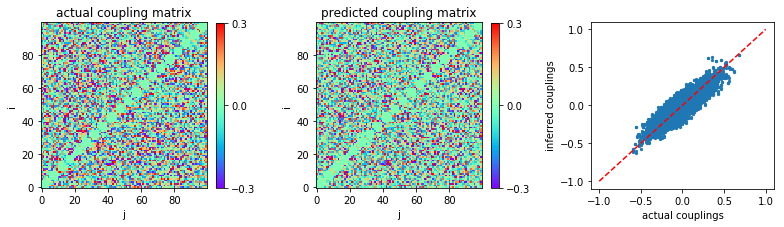

In [20]:
plt.figure(figsize=(11,3.2))

plt.subplot2grid((1,3),(0,0))
plt.title('actual coupling matrix')
plt.imshow(w_true,cmap='rainbow',origin='lower')
plt.xlabel('j')
plt.ylabel('i')
plt.clim(-0.3,0.3)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.3,0,0.3])

plt.subplot2grid((1,3),(0,1))
plt.title('predicted coupling matrix')
plt.imshow(w,cmap='rainbow',origin='lower')
plt.xlabel('j')
plt.ylabel('i')
plt.clim(-0.3,0.3)
plt.colorbar(fraction=0.045, pad=0.05,ticks=[-0.3,0,0.3])

plt.subplot2grid((1,3),(0,2))
plt.plot([-1.,1.],[-1.,1.],'r--')
plt.scatter(w_true,w,marker='o',s=5)
plt.xlabel('actual couplings')
plt.ylabel('inferred couplings')

plt.tight_layout(h_pad=1, w_pad=1.5)
plt.show()

In [21]:
mse = ((w_true - w)**2).mean()
print(mse)

0.006675730455447975


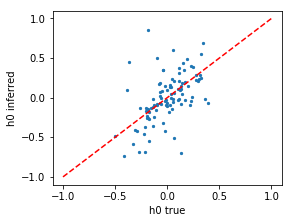

In [22]:
plt.figure(figsize=(11,3.2))
plt.subplot2grid((1,3),(0,0))

plt.plot([-1.,1.],[-1.,1.],'r--')
plt.scatter(h0_true,h0,marker='o',s=5)
plt.xlabel('h0 true')
plt.ylabel('h0 inferred')
plt.tight_layout(h_pad=1, w_pad=1.5)
plt.show()